In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
# import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
% ls -1 data/

test_seas2_0.871.csv
test_seas_0.104.csv


In [3]:
df_01 = pd.read_csv('data/test_seas_0.104.csv')
df_09 = pd.read_csv('data/test_seas2_0.871.csv')

In [4]:
df_01.shape

(200, 10000)

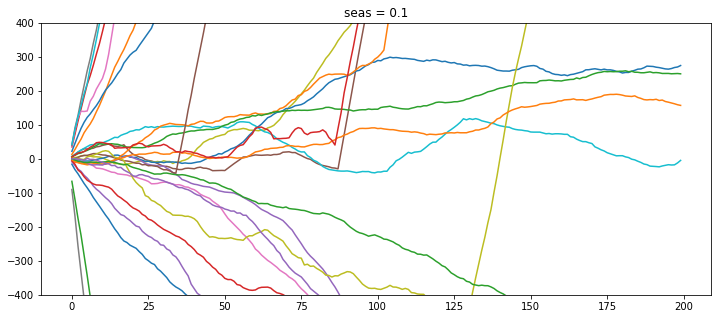

In [5]:
df_01.sample(25, random_state=123, axis=1).\
      plot(linestyle='-',
           marker=None, logy=False,
           legend=False, figsize=(12,5),
           ylim=(-400,400),
           title='seas = 0.1'
          );

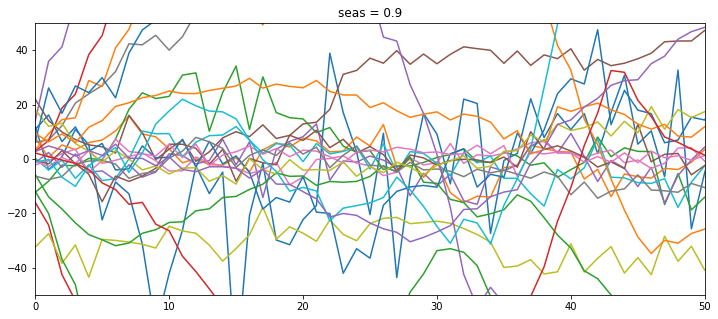

In [6]:
df_09.sample(25,random_state=123, axis=1).\
      plot(linestyle='-', logy=False,
           legend=False, figsize=(12,5),
           ylim=(-50,50), xlim=(0, 50),
           title='seas = 0.9');

## Making datasets + Preprocessing
We do following:

1) add min value to makes TS positive.

2) log.

3) divide by max in order to make $TS \in [0,1]$.


In [7]:
def norm_ts(data):
    """
    1) add min value to makes TS positive. 
    2) log. 
    3) divide by max in order to make  TS∈[0,1] .
    """
    min_val = np.min(data, axis=1)[:, np.newaxis]
    data_log = np.log(data - min_val + 1)
    scaler = MinMaxScaler(copy=False)
    scaled01 = scaler.fit_transform(data_log.T).T
    return scaled01, scaler, min_val

In [8]:
data_01 = df_01.values.T
data_09 = df_09.values.T
data_01_09 = np.concatenate((data_01, data_09), axis=0)

data_01_norm, scaler, min01 = norm_ts(data_01)
data_09_norm, scaler, min09 = norm_ts(data_09)
data_01_09_norm = np.concatenate((data_01_norm, data_09_norm), axis=0)


## Let's plot after

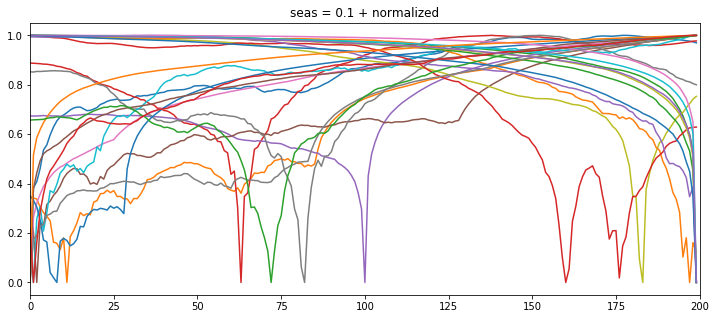

In [9]:
pd.DataFrame(data_01_norm.T).\
                              sample(25, random_state=124, axis=1).\
                              plot(linestyle='-', logy=False,
                              legend=False, figsize=(12,5),xlim=(0, 200),
                              title='seas = 0.1 + normalized');

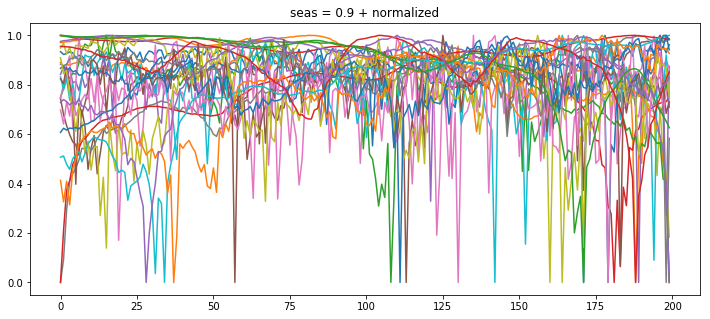

In [10]:
pd.DataFrame(data_09_norm.T).\
                              sample(25, random_state=123, axis=1).\
                              plot(linestyle='-', logy=False,
                              legend=False, figsize=(12,5),
                              title='seas = 0.9 + normalized');

In [11]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution1D, Flatten, BatchNormalization, Dropout
from keras import optimizers
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


Using TensorFlow backend.


In [12]:
def mse(Y, YH):
     return np.square(Y - YH).mean()
    

def train_test_split_reshape(data, n_steps_for_train=175):
    """reshape + split train test 50-50"""
    np.random.seed(seed=123)
    np.random.shuffle(data)
    n_samples = data.shape[0]
    x_train = data[:n_samples/2, :n_steps_for_train].reshape(n_samples/2, n_steps_for_train, 1)
    y_train = data[:n_samples/2, n_steps_for_train:]

    x_test = data[n_samples/2:, :n_steps_for_train].reshape(n_samples/2, n_steps_for_train, 1)
    y_test = data[n_samples/2:, n_steps_for_train:]
    return x_train, y_train, x_test, y_test


def naive_prediction_mae():
    naive_pred = 0
    n = x_test.shape[0]
    for i in range(n): 
        naive_pred += np.mean(np.abs(x_test[i, -1] - y_test[i, :]))
    naive_pred /= n
    print 'naive model = {0:0.4f}'.format(naive_pred)
    return None

def model_mae(model):
    y_pred = model.predict(x_test)
    mae = 0
    n = x_test.shape[0]
    for i in range(n): 
        mae += np.mean(np.abs(y_pred[i, :] - y_test[i, :]))
    mae /= n
    print 'current model = {0:0.4f}'.format(mae)
    return mae

In [13]:
def cnn_model(x_train, y_train, batch_size, epochs=100, n_steps_for_train=175):
    
    
    input_dim = n_steps_for_train
    model = Sequential()
    model.add(Convolution1D(filters=6, kernel_size=4, input_shape=(input_dim ,1)))
    model.add(Flatten())
    model.add(Dense(units=64, kernel_initializer='normal'))
    # model.add(BatchNormalization())
    model.add(Activation('relu'))
    # model.add(Dropout(0.5))
    # model.add(Dense(units=60, actiivation='relu'))
    # model.add(Dense(units=40, activation='relu'))
    model.add(Dense(units=200-input_dim, activation='linear'))


    sgd = optimizers.SGD(lr=0.1)
    model.compile(loss='mean_squared_error',
                  optimizer='sgd',
                  metrics=['mae'])

    history = model.fit(x_train, y_train, epochs=epochs, shuffle=True, batch_size=batch_size, validation_split=.3, verbose=2)
    return model, history

## CNN for 2 cluster together

In [14]:
x_train, y_train, x_test, y_test = train_test_split_reshape(data_01_09_norm)

In [15]:
model, history = cnn_model(x_train=x_train, y_train=y_train, batch_size=4)

Train on 7000 samples, validate on 3000 samples
Epoch 1/100
 - 4s - loss: 0.0410 - mean_absolute_error: 0.1436 - val_loss: 0.0305 - val_mean_absolute_error: 0.1209
Epoch 2/100
 - 4s - loss: 0.0265 - mean_absolute_error: 0.1104 - val_loss: 0.0266 - val_mean_absolute_error: 0.1098
Epoch 3/100
 - 4s - loss: 0.0241 - mean_absolute_error: 0.1030 - val_loss: 0.0251 - val_mean_absolute_error: 0.1038
Epoch 4/100
 - 4s - loss: 0.0227 - mean_absolute_error: 0.0987 - val_loss: 0.0242 - val_mean_absolute_error: 0.1012
Epoch 5/100
 - 4s - loss: 0.0217 - mean_absolute_error: 0.0958 - val_loss: 0.0230 - val_mean_absolute_error: 0.0991
Epoch 6/100
 - 4s - loss: 0.0210 - mean_absolute_error: 0.0938 - val_loss: 0.0221 - val_mean_absolute_error: 0.0930
Epoch 7/100
 - 4s - loss: 0.0204 - mean_absolute_error: 0.0923 - val_loss: 0.0216 - val_mean_absolute_error: 0.0930
Epoch 8/100
 - 4s - loss: 0.0199 - mean_absolute_error: 0.0911 - val_loss: 0.0213 - val_mean_absolute_error: 0.0915
Epoch 9/100
 - 5s - loss

Epoch 71/100
 - 5s - loss: 0.0123 - mean_absolute_error: 0.0667 - val_loss: 0.0133 - val_mean_absolute_error: 0.0676
Epoch 72/100
 - 5s - loss: 0.0123 - mean_absolute_error: 0.0664 - val_loss: 0.0141 - val_mean_absolute_error: 0.0735
Epoch 73/100
 - 5s - loss: 0.0123 - mean_absolute_error: 0.0662 - val_loss: 0.0136 - val_mean_absolute_error: 0.0684
Epoch 74/100
 - 4s - loss: 0.0122 - mean_absolute_error: 0.0660 - val_loss: 0.0130 - val_mean_absolute_error: 0.0664
Epoch 75/100
 - 5s - loss: 0.0121 - mean_absolute_error: 0.0658 - val_loss: 0.0135 - val_mean_absolute_error: 0.0721
Epoch 76/100
 - 5s - loss: 0.0121 - mean_absolute_error: 0.0657 - val_loss: 0.0130 - val_mean_absolute_error: 0.0664
Epoch 77/100
 - 5s - loss: 0.0120 - mean_absolute_error: 0.0654 - val_loss: 0.0131 - val_mean_absolute_error: 0.0698
Epoch 78/100
 - 5s - loss: 0.0120 - mean_absolute_error: 0.0655 - val_loss: 0.0131 - val_mean_absolute_error: 0.0663
Epoch 79/100
 - 5s - loss: 0.0119 - mean_absolute_error: 0.0652 

In [16]:
naive_prediction_mae()
r_01_09 = model_mae(model)

naive model = 0.0983
current model = 0.0634


/Users/mdymshits/virtualenv/ir-threat/lib/python2.7/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


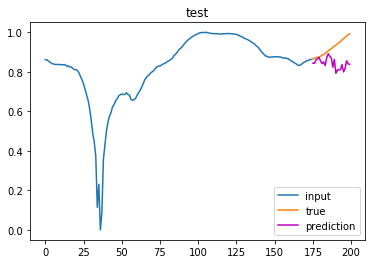

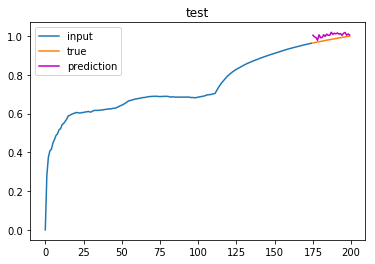

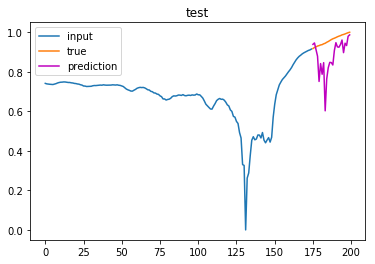

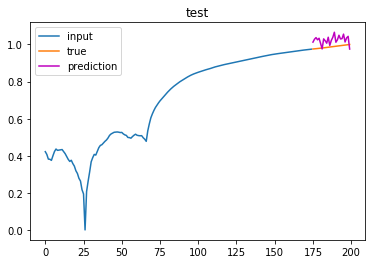

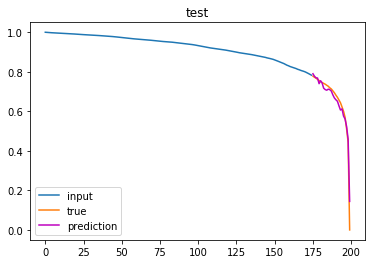

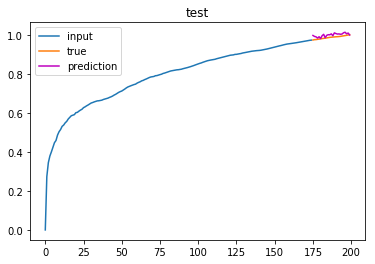

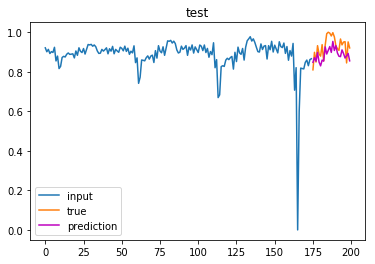

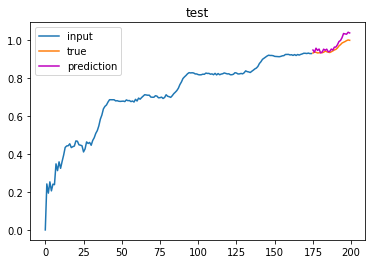

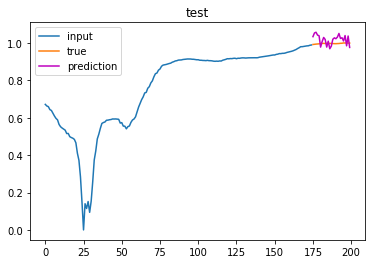

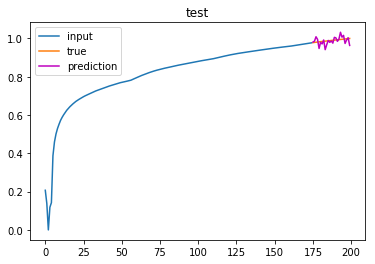

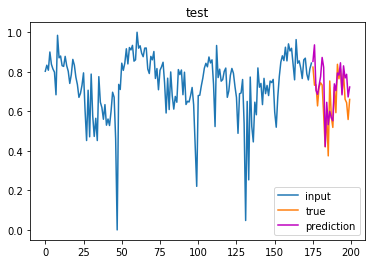

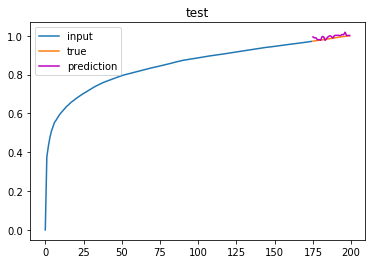

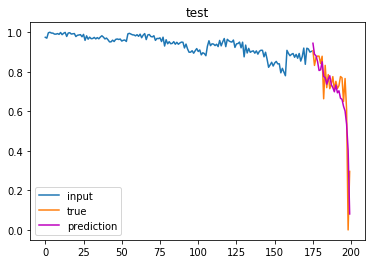

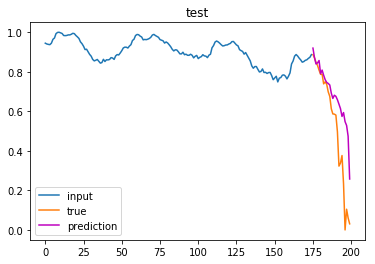

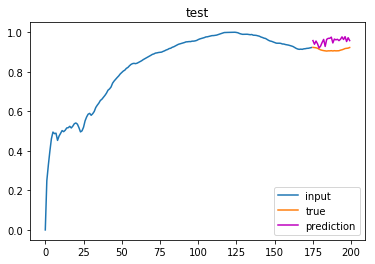

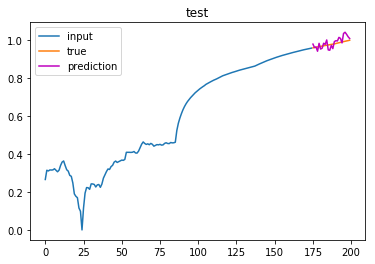

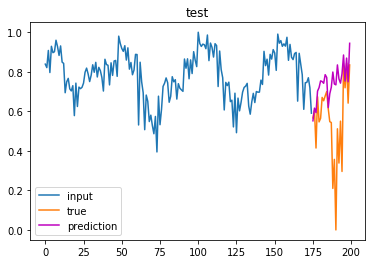

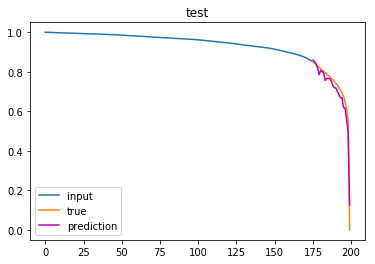

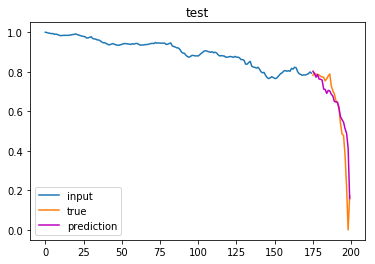

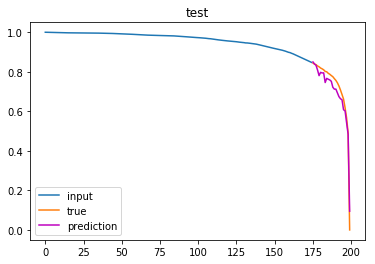

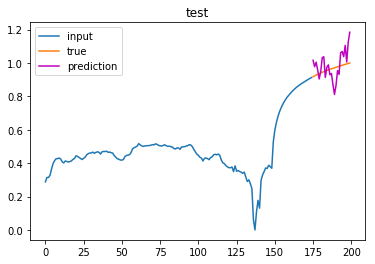

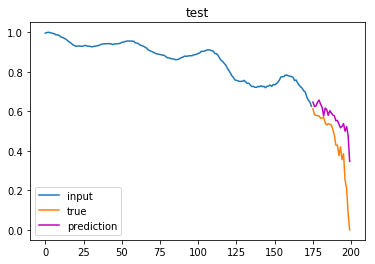

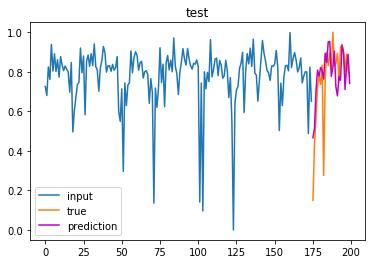

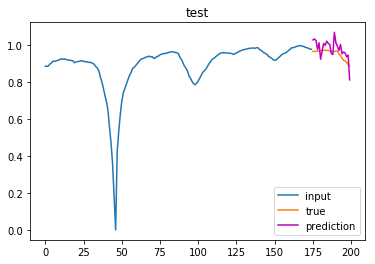

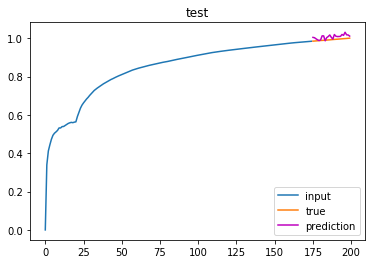

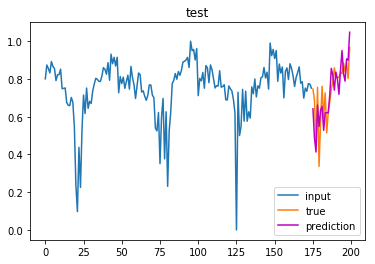

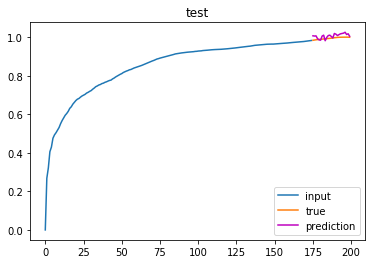

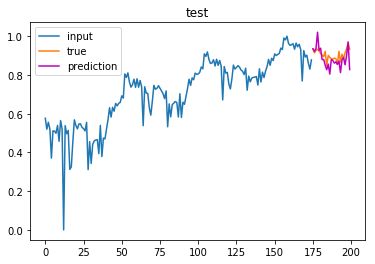

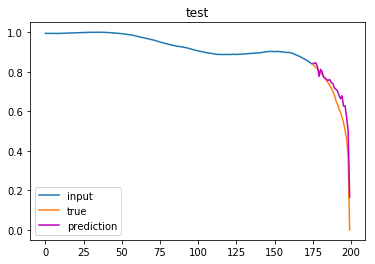

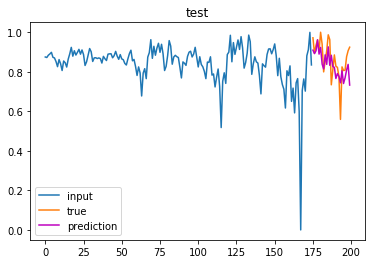

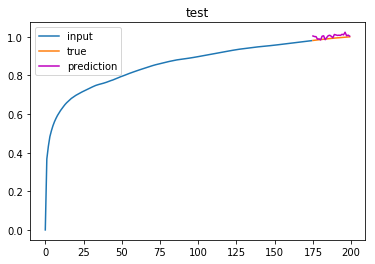

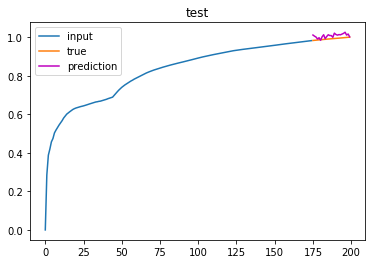

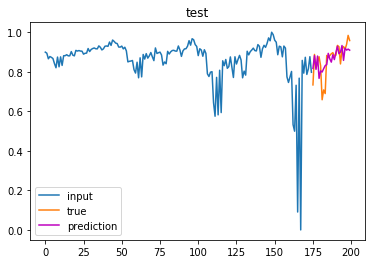

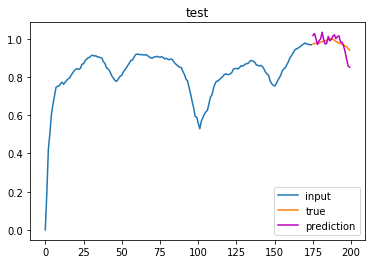

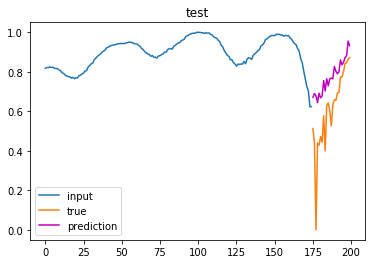

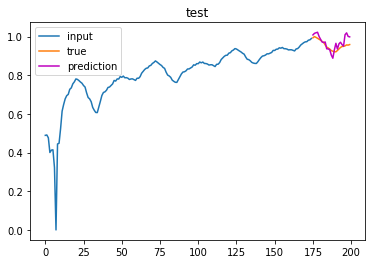

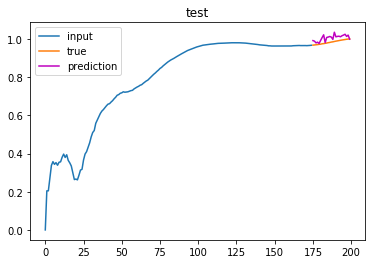

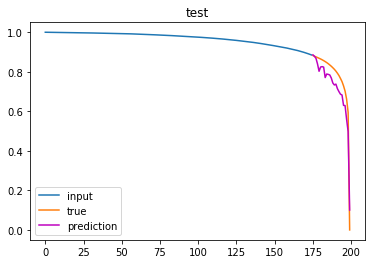

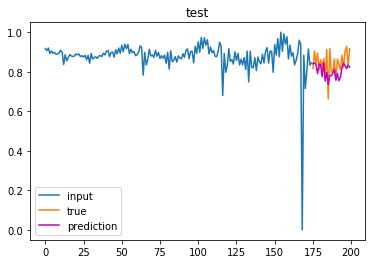

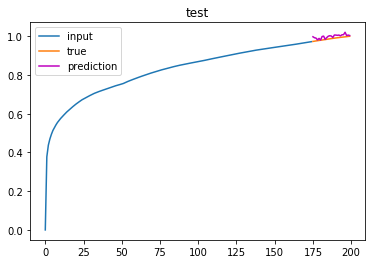

In [17]:
y_pred = model.predict(x_test)

for i in range(40):
    plt.figure()
    plt.plot(range(175), x_test[i], label='input')
    plt.plot(range(175, 200), y_test[i], label='true')
    plt.plot(range(175, 200), y_pred[i], c='m', label='prediction')
    plt.title('test')
    plt.legend()

## CNN for "low seasonality cluster"

In [18]:
x_train, y_train, x_test, y_test = train_test_split_reshape(data_01_norm)
model, history = cnn_model(x_train=x_train, y_train=y_train, batch_size=4)

Train on 3500 samples, validate on 1500 samples
Epoch 1/100
 - 3s - loss: 0.0453 - mean_absolute_error: 0.1502 - val_loss: 0.0240 - val_mean_absolute_error: 0.1006
Epoch 2/100
 - 2s - loss: 0.0193 - mean_absolute_error: 0.0907 - val_loss: 0.0178 - val_mean_absolute_error: 0.0861
Epoch 3/100
 - 2s - loss: 0.0157 - mean_absolute_error: 0.0790 - val_loss: 0.0150 - val_mean_absolute_error: 0.0732
Epoch 4/100
 - 2s - loss: 0.0141 - mean_absolute_error: 0.0730 - val_loss: 0.0139 - val_mean_absolute_error: 0.0725
Epoch 5/100
 - 3s - loss: 0.0129 - mean_absolute_error: 0.0697 - val_loss: 0.0130 - val_mean_absolute_error: 0.0695
Epoch 6/100
 - 2s - loss: 0.0123 - mean_absolute_error: 0.0670 - val_loss: 0.0122 - val_mean_absolute_error: 0.0663
Epoch 7/100
 - 2s - loss: 0.0117 - mean_absolute_error: 0.0650 - val_loss: 0.0117 - val_mean_absolute_error: 0.0620
Epoch 8/100
 - 2s - loss: 0.0113 - mean_absolute_error: 0.0634 - val_loss: 0.0116 - val_mean_absolute_error: 0.0650
Epoch 9/100
 - 2s - loss

Epoch 71/100
 - 2s - loss: 0.0053 - mean_absolute_error: 0.0392 - val_loss: 0.0058 - val_mean_absolute_error: 0.0439
Epoch 72/100
 - 2s - loss: 0.0053 - mean_absolute_error: 0.0391 - val_loss: 0.0052 - val_mean_absolute_error: 0.0371
Epoch 73/100
 - 2s - loss: 0.0053 - mean_absolute_error: 0.0388 - val_loss: 0.0072 - val_mean_absolute_error: 0.0583
Epoch 74/100
 - 2s - loss: 0.0052 - mean_absolute_error: 0.0387 - val_loss: 0.0054 - val_mean_absolute_error: 0.0390
Epoch 75/100
 - 2s - loss: 0.0051 - mean_absolute_error: 0.0385 - val_loss: 0.0067 - val_mean_absolute_error: 0.0514
Epoch 76/100
 - 2s - loss: 0.0052 - mean_absolute_error: 0.0383 - val_loss: 0.0050 - val_mean_absolute_error: 0.0364
Epoch 77/100
 - 2s - loss: 0.0052 - mean_absolute_error: 0.0384 - val_loss: 0.0053 - val_mean_absolute_error: 0.0393
Epoch 78/100
 - 2s - loss: 0.0051 - mean_absolute_error: 0.0380 - val_loss: 0.0051 - val_mean_absolute_error: 0.0384
Epoch 79/100
 - 2s - loss: 0.0052 - mean_absolute_error: 0.0381 

In [19]:
naive_prediction_mae()
r_01 = model_mae(model)

naive model = 0.0636
current model = 0.0350


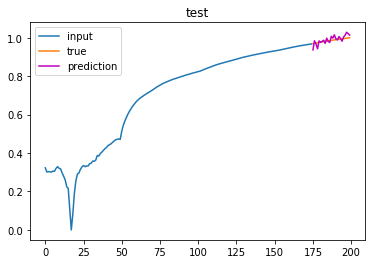

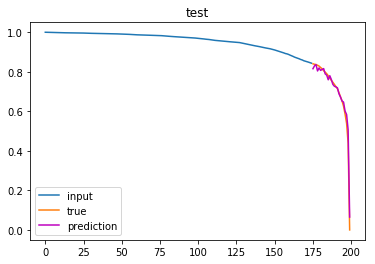

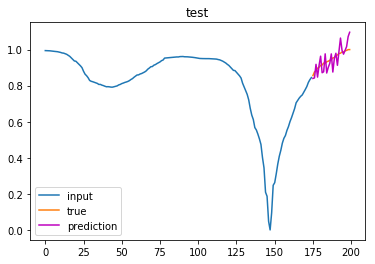

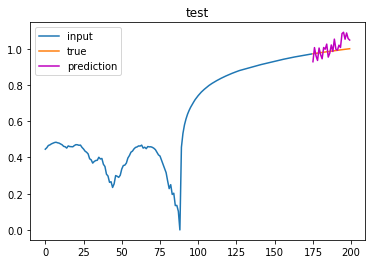

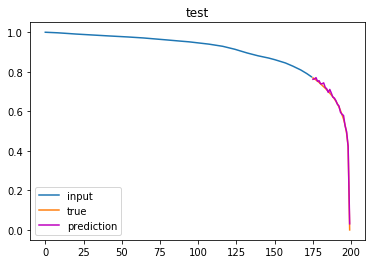

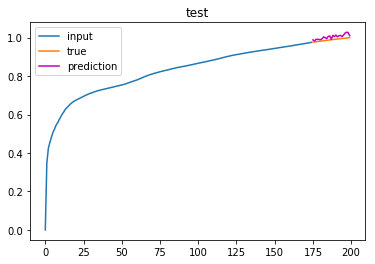

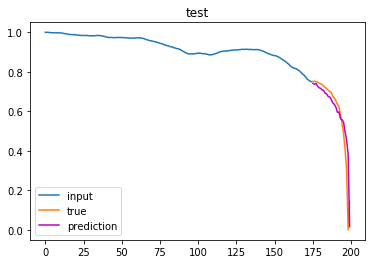

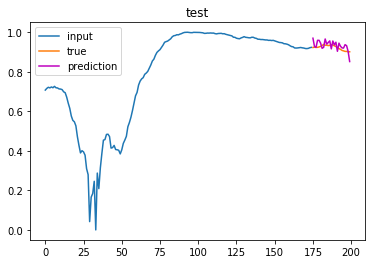

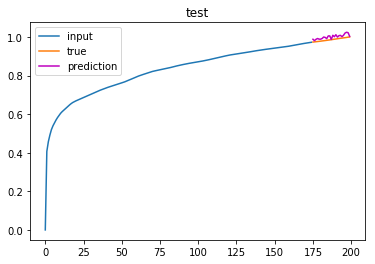

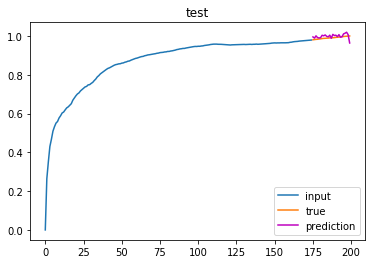

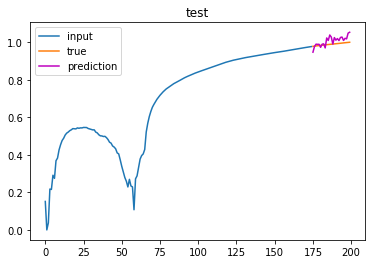

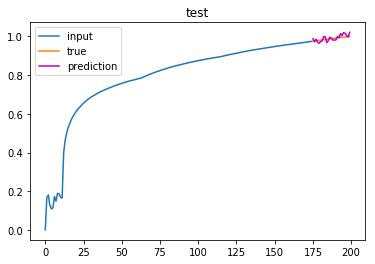

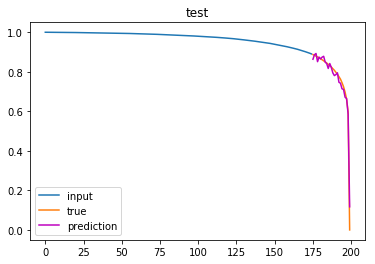

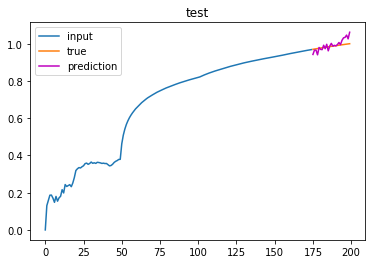

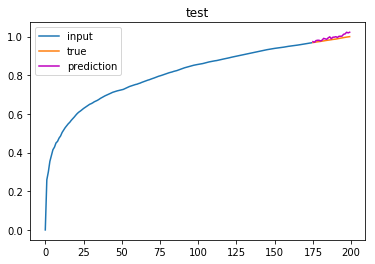

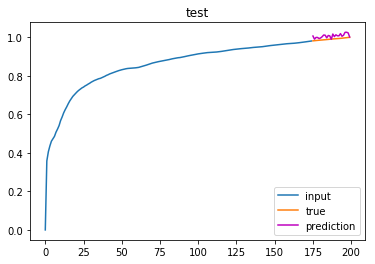

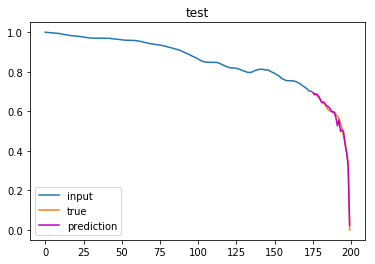

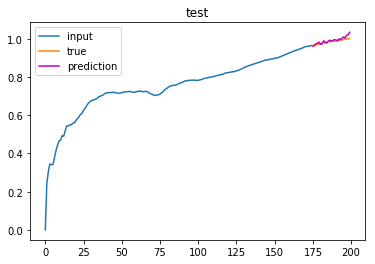

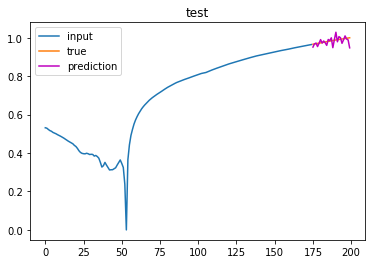

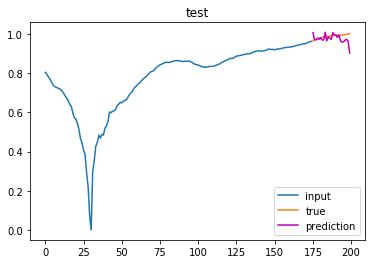

In [20]:
y_pred = model.predict(x_test)

for i in range(20):
    plt.figure()
    plt.plot(range(175), x_test[i], label='input')
    plt.plot(range(175, 200), y_test[i], label='true')
    plt.plot(range(175, 200), y_pred[i], c='m', label='prediction')
    plt.title('test')
    plt.legend()

## CNN for "high seasonality cluster"

In [21]:
x_train, y_train, x_test, y_test = train_test_split_reshape(data_09_norm)
model, history = cnn_model(x_train=x_train, y_train=y_train, batch_size=4)

Train on 3500 samples, validate on 1500 samples
Epoch 1/100
 - 1s - loss: 0.0504 - mean_absolute_error: 0.1601 - val_loss: 0.0359 - val_mean_absolute_error: 0.1312
Epoch 2/100
 - 1s - loss: 0.0337 - mean_absolute_error: 0.1304 - val_loss: 0.0311 - val_mean_absolute_error: 0.1224
Epoch 3/100
 - 1s - loss: 0.0300 - mean_absolute_error: 0.1207 - val_loss: 0.0295 - val_mean_absolute_error: 0.1138
Epoch 4/100
 - 1s - loss: 0.0281 - mean_absolute_error: 0.1153 - val_loss: 0.0279 - val_mean_absolute_error: 0.1200
Epoch 5/100
 - 1s - loss: 0.0269 - mean_absolute_error: 0.1122 - val_loss: 0.0258 - val_mean_absolute_error: 0.1101
Epoch 6/100
 - 1s - loss: 0.0260 - mean_absolute_error: 0.1096 - val_loss: 0.0257 - val_mean_absolute_error: 0.1060
Epoch 7/100
 - 1s - loss: 0.0252 - mean_absolute_error: 0.1073 - val_loss: 0.0245 - val_mean_absolute_error: 0.1019
Epoch 8/100
 - 1s - loss: 0.0247 - mean_absolute_error: 0.1056 - val_loss: 0.0239 - val_mean_absolute_error: 0.1015
Epoch 9/100
 - 1s - loss

Epoch 71/100
 - 1s - loss: 0.0173 - mean_absolute_error: 0.0838 - val_loss: 0.0169 - val_mean_absolute_error: 0.0850
Epoch 72/100
 - 1s - loss: 0.0172 - mean_absolute_error: 0.0836 - val_loss: 0.0175 - val_mean_absolute_error: 0.0798
Epoch 73/100
 - 1s - loss: 0.0171 - mean_absolute_error: 0.0834 - val_loss: 0.0166 - val_mean_absolute_error: 0.0794
Epoch 74/100
 - 1s - loss: 0.0171 - mean_absolute_error: 0.0833 - val_loss: 0.0166 - val_mean_absolute_error: 0.0799
Epoch 75/100
 - 1s - loss: 0.0170 - mean_absolute_error: 0.0831 - val_loss: 0.0168 - val_mean_absolute_error: 0.0796
Epoch 76/100
 - 1s - loss: 0.0170 - mean_absolute_error: 0.0831 - val_loss: 0.0171 - val_mean_absolute_error: 0.0800
Epoch 77/100
 - 1s - loss: 0.0170 - mean_absolute_error: 0.0829 - val_loss: 0.0168 - val_mean_absolute_error: 0.0788
Epoch 78/100
 - 1s - loss: 0.0170 - mean_absolute_error: 0.0828 - val_loss: 0.0172 - val_mean_absolute_error: 0.0881
Epoch 79/100
 - 1s - loss: 0.0169 - mean_absolute_error: 0.0825 

In [22]:
naive_prediction_mae()
r_09 = model_mae(model)

naive model = 0.1309
current model = 0.0813


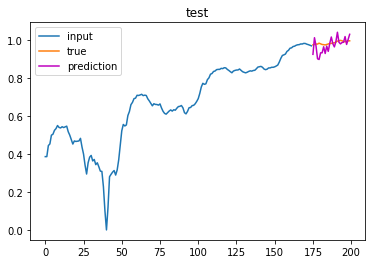

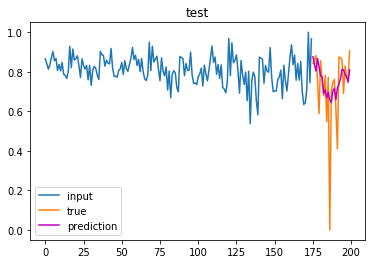

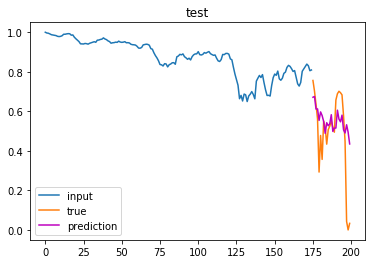

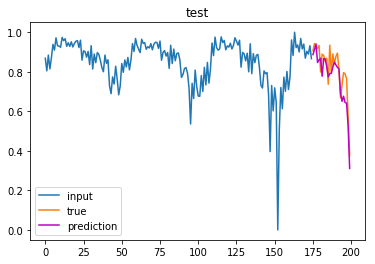

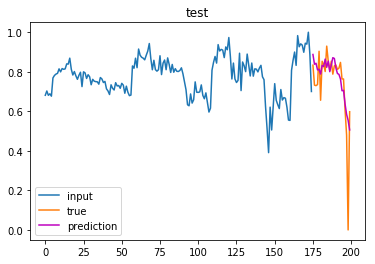

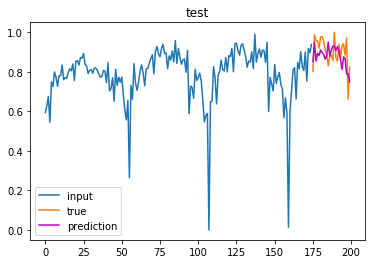

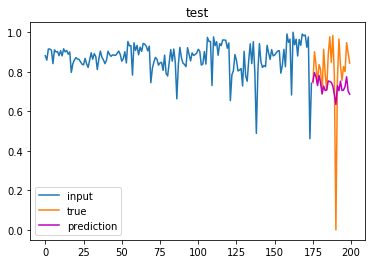

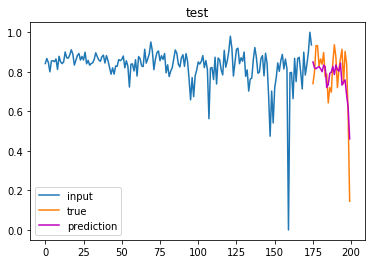

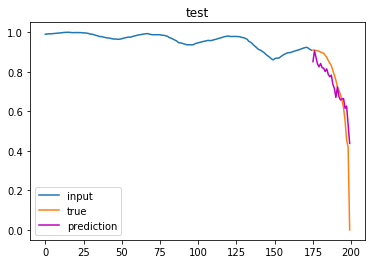

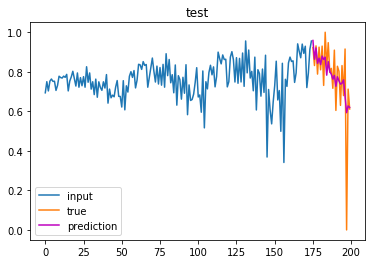

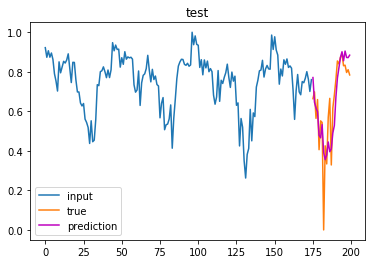

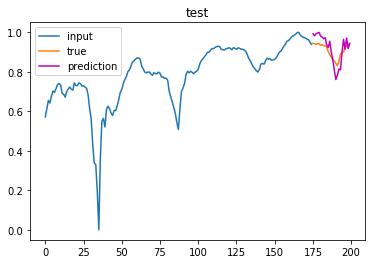

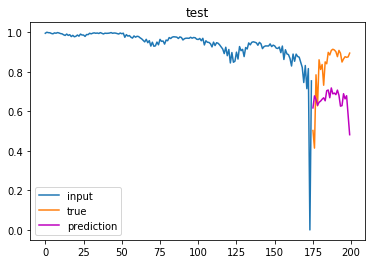

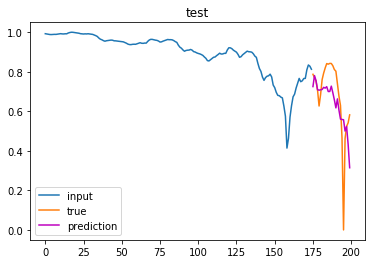

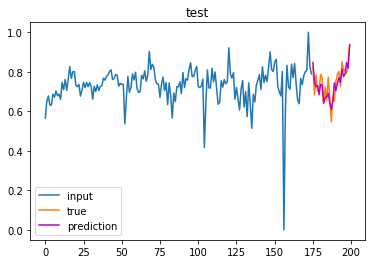

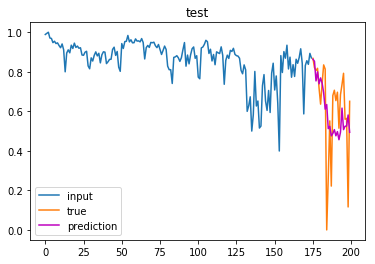

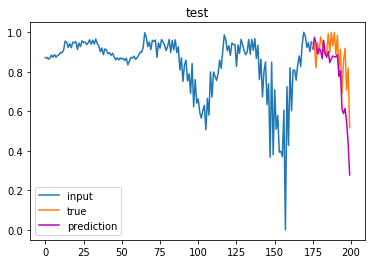

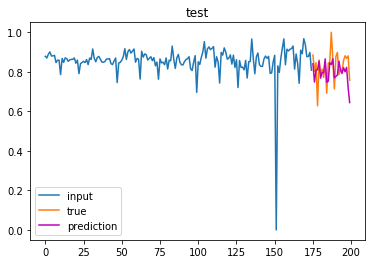

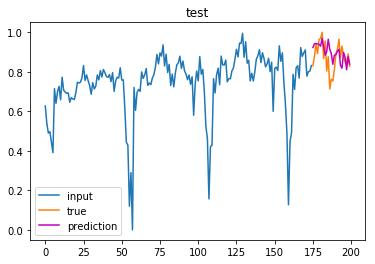

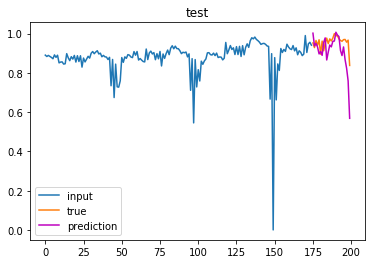

In [23]:
y_pred = model.predict(x_test)

for i in range(20):
    plt.figure()
    plt.plot(range(175), x_test[i], label='input')
    plt.plot(range(175, 200), y_test[i], label='true')
    plt.plot(range(175, 200), y_pred[i], c='m', label='prediction')
    plt.title('test')
    plt.legend()

In [30]:

r_01_plus_09 = (r_01 + r_09) / 2
print 'res = {0:0.3f}'.format(r_01_plus_09)

res = 0.058


In [29]:
print 'res = {0:0.3f}'.format(r_01_09)

res = 0.063


In [32]:
print 'res = {0:0.2f} %'.format(np.abs(r_01_plus_09 - r_01_09) / r_01_plus_09 * 100)

res = 9.02 %
